In [16]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)


Device: grpc://10.0.0.2:8470
Number of replicas: 8
2.4.1


In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 25

In [18]:
filenames = tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [19]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1068
Pneumonia images count in training set: 3117


In [20]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'gs://kds-2b5424a9864b139493790baaa37ae8a098f8d91c9639c3478283e4a6/chest_xray/train/PNEUMONIA/person1710_bacteria_4525.jpeg'
b'gs://kds-2b5424a9864b139493790baaa37ae8a098f8d91c9639c3478283e4a6/chest_xray/train/PNEUMONIA/person457_bacteria_1949.jpeg'
b'gs://kds-2b5424a9864b139493790baaa37ae8a098f8d91c9639c3478283e4a6/chest_xray/train/NORMAL/IM-0693-0001.jpeg'
b'gs://kds-2b5424a9864b139493790baaa37ae8a098f8d91c9639c3478283e4a6/chest_xray/train/PNEUMONIA/person124_virus_242.jpeg'
b'gs://kds-2b5424a9864b139493790baaa37ae8a098f8d91c9639c3478283e4a6/chest_xray/train/NORMAL/IM-0751-0001.jpeg'


In [21]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [22]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(GCS_PATH + "/chest_xray/train/*"))])
CLASS_NAMES

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

In [23]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

In [24]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [25]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [26]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [27]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [28]:
test_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

624

In [29]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [30]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [31]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

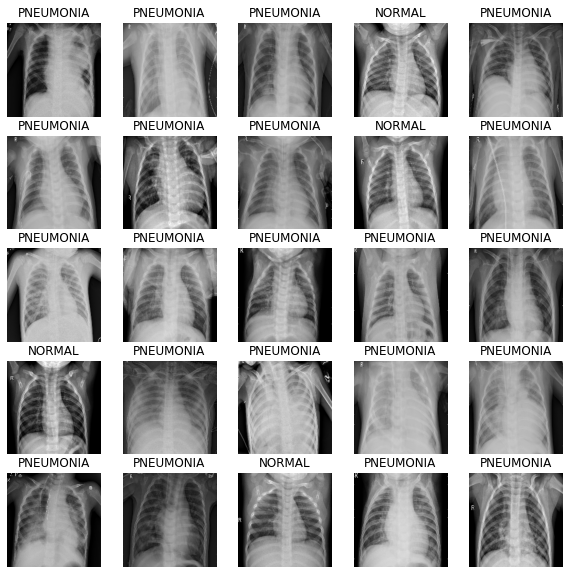

In [32]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [33]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [34]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [35]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [36]:
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
initial_bias

array([1.07108326])

In [37]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.96
Weight for class 1: 0.67


In [38]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [39]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/25
32/32 [==============================] - 152s 4s/step - loss: 0.6163 - accuracy: 0.6794 - precision: 0.8985 - recall: 0.6435 - val_loss: 0.6254 - val_accuracy: 0.7305 - val_precision: 0.7305 - val_recall: 1.0000
Epoch 2/25
32/32 [==============================] - 3s 84ms/step - loss: 0.3877 - accuracy: 0.8203 - precision: 0.9737 - recall: 0.7835 - val_loss: 0.5823 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 3/25
32/32 [==============================] - 3s 82ms/step - loss: 0.2718 - accuracy: 0.8914 - precision: 0.9764 - recall: 0.8747 - val_loss: 0.6156 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 4/25
32/32 [==============================] - 3s 82ms/step - loss: 0.2343 - accuracy: 0.9058 - precision: 0.9749 - recall: 0.8980 - val_loss: 0.6628 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 5/25
32/32 [==============================] - 3s 81ms/step - loss: 0.2574 - accuracy: 0.9037 - precisi

In [40]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [41]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [42]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=100,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/100
32/32 [==============================] - 3s 84ms/step - loss: 0.2785 - accuracy: 0.8879 - precision: 0.9579 - recall: 0.8884 - val_loss: 6433.5596 - val_accuracy: 0.2676 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
32/32 [==============================] - 3s 79ms/step - loss: 0.2508 - accuracy: 0.8931 - precision: 0.9743 - recall: 0.8799 - val_loss: 401.1253 - val_accuracy: 0.2686 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
32/32 [==============================] - 3s 81ms/step - loss: 0.1863 - accuracy: 0.9321 - precision: 0.9786 - recall: 0.9292 - val_loss: 2.8261 - val_accuracy: 0.8936 - val_precision: 0.9371 - val_recall: 0.9158
Epoch 4/100
32/32 [==============================] - 3s 81ms/step - loss: 0.1704 - accuracy: 0.9294 - precision: 0.9822 - recall: 0.9221 - val_loss: 7.5413 - val_accuracy: 0.4297 - val_precision: 1.0000 - val_recall: 0.2224
Epoch 5/100
32/32 [==============================] - 3s 82ms/step - loss: 0.1686 - 

# 8. Visualizing model performance

Let's plot the model accuracy and loss for the training and the validating set. These plots show the accuracy and loss values for the second round of training. Since we initially trained the model with 30 epochs, these would be epochs 31-45. Note that no random seed is specified for this notebook. For your notebook, there might be slight variance.

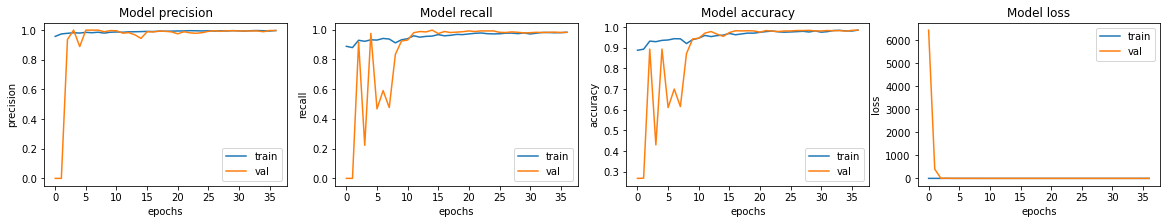

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

We see that the accuracy for our model is around 98%. Finetune the model further to see if we can achieve a higher accuracy.

In [44]:
loss, acc, prec, rec = model.evaluate(test_ds)

5/5 [==============================] - 22s 4s/step - loss: 0.9185 - accuracy: 0.7837 - precision: 0.7476 - recall: 0.9872


In [45]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("newmodel.h5")
print("Saved model to disk")

Saved model to disk


In [47]:
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
model=load_model('xray_model.h5')
img=image.load_img('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg',target_size=(224,224))

In [ ]:
x=image.img_to_array(img)
x=np.expand_dims(x, axis=0)
img_data=preprocess_input(x)
classes=model.predict(img_data)
result=int(classes[0][0])
if result==0:
    print("Person is Affected By PNEUMONIA")
else:
    print("Result is Normal")